In [80]:
from dotenv import load_dotenv

load_dotenv()

True

In [81]:
def add(a:int, b:int)-> int:
    """Adds a and b
    
    Args:
        a: first int
        b: second int
    """
    return a+b

def multiply(a:int, b:int)-> int:
    """Multiply a and b
    
    Args:
        a: first int
        b: second int
    """
    return a*b

def divide(a:int, b:int)-> float:
    """Divide a and b
    
    Args:
        a: first int
        b: second int
    """
    return a/b

In [82]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

In [83]:
from langchain_community.tools import ArxivQueryRun
from langchain_community.utilities import ArxivAPIWrapper

api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=5000)
arxiv= ArxivQueryRun(api_wrapper=api_wrapper_arxiv)

In [84]:
tools = [arxiv, tavily, add, multiply, divide]

In [85]:
from langchain_classic.chat_models import init_chat_model

llm= init_chat_model("groq:qwen/qwen3-32b")

llm_with_tools = llm.bind_tools(tools)

In [86]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

llm_with_tools.invoke([HumanMessage(content="What is the recent AI news")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent AI news. I need to figure out which tool to use here. Let me check the available functions.\n\nFirst, there\'s the arxiv function, which is for scientific articles in fields like physics and computer science. But the user is asking about news, not academic papers. So maybe not the best fit.\n\nNext, there\'s tavily_search_results_json. The description says it\'s a search engine for comprehensive and current results, useful for current events. That sounds perfect because the user wants recent news.\n\nThen there are the math functions: add, multiply, divide. Those don\'t seem relevant here at all. The user isn\'t asking for any calculations.\n\nSo I should use the tavily_search_results_json function. The input needs to be a search query. The user\'s query is "recent AI news", so I\'ll use that as the query parameter.\n\nI need to make sure the function call is formatted correctly. The para

In [87]:
llm_with_tools.invoke([HumanMessage(content="What is the recent AI news")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': '8gb39gjvd',
  'type': 'tool_call'}]

In [88]:
from typing import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

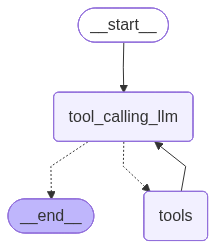

In [89]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


# Node definition
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# Building Graph
builder = StateGraph(State)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges( # if the latest message from the tool_calling_llm(assistant) is a tool call  -> tool condition routes to tools otherwise routes to end
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", "tool_calling_llm")


graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [90]:
messages = graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news from 11 November 2025, add 6 plus 6 and then multiply by 10")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news from 11 November 2025, add 6 plus 6 and then multiply by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (g9qs74qke)
 Call ID: g9qs74qke
  Args:
    query: top 10 recent AI news 2025
  add (qjnzdj56z)
 Call ID: qjnzdj56z
  Args:
    a: 6
    b: 6
  multiply (r02xbw4zf)
 Call ID: r02xbw4zf
  Args:
    a: 12
    b: 10
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "The 10 Biggest News Stories Of 2025 (So Far)", "url": "https://www.crn.com/news/channel-news/2025/the-10-biggest-news-stories-of-2025-so-far", "content": "# The 10 Biggest News Stories Of 2025 (So Far)\n\nThis year’s leading news stories (so far) include the wave of agentic AI technology development, tariffs and economic uncertainty, the mixed fortunes of N

In [91]:
messages = [HumanMessage(content="Divide that by 5")]
messages= graph.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Divide that by 5
================================== Ai Message ==================================

I need the number you want to divide by 5. What is the dividend?


### Memory Saver

LangGraph can use acheckpointer to automatically save the graph state after each step.

This built in persistence layer gives us memory allowing LangGraph to pick up from the last state update.

One of the easiest checkpointers to use is the MemorySaver, an in-memory key-value store for Graph State.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

In [92]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


# Node definition
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# Building Graph
builder = StateGraph(State)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges( # if the latest message from the tool_calling_llm(assistant) is a tool call  -> tool condition routes to tools otherwise routes to end
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", "tool_calling_llm")



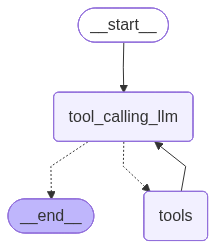

In [93]:
from langgraph.checkpoint.memory import MemorySaver

memory= MemorySaver()
graph_memory = builder.compile(checkpointer=memory)

# View
display(Image(graph_memory.get_graph().draw_mermaid_png()))

In [94]:
## Specify the thread

config={"configurable":{"thread_id":"1"}}
# Specify an Input
messages = [HumanMessage(content="Add 12 and 13.")]

messages = graph_memory.invoke({"messages":messages}, config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (2m49vjxr4)
 Call ID: 2m49vjxr4
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is **25**.

Final answer: 12 + 13 = 25


In [95]:
messages = [HumanMessage(content="Add that number to 25")]

messages = graph_memory.invoke({"messages":messages}, config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (2m49vjxr4)
 Call ID: 2m49vjxr4
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is **25**.

Final answer: 12 + 13 = 25
================================ Human Message =================================

Add that number to 25
================================== Ai Message ==================================
Tool Calls:
  add (h2zcmdmnw)
 Call ID: h2zcmdmnw
  Args:
    a: 25
    b: 25
================================= Tool Message =================================
Name: add

50
================================== Ai Message ==================================

The sum of 25 and 25 is **50**.

Final answer: 25 + 25 = 50


In [96]:
messages = [HumanMessage(content="Then multiply that number to 2")]

messages = graph_memory.invoke({"messages":messages}, config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (2m49vjxr4)
 Call ID: 2m49vjxr4
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is **25**.

Final answer: 12 + 13 = 25
================================ Human Message =================================

Add that number to 25
================================== Ai Message ==================================
Tool Calls:
  add (h2zcmdmnw)
 Call ID: h2zcmdmnw
  Args:
    a: 25
    b: 25
================================= Tool Message =================================
Name: add

50
================================== Ai Message ==================================

The sum of 25 and 25 is **50**.

Final answer: 25 + 25 = 50
=======